---
```
   Copyright 2016 Erik Jan de Vries

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```
---

# OpenAI Gym Catch environment

In this notebook we will implement an [OpenAI Gym](https://gym.openai.com/) environment for the game Catch.

## Catch

Catch is a game in which fruit is dropping from a tree and you have to catch the fruit with your basket. The setup is very simple: the game area consists of a 10x10 grid. The fruit is in one cell, the basket covers three cells at the bottom of the game area. The fruit drops one cell per timestep and you can move the basket left or right (or you can choose not to move it). When the fruit reaches the bottom of the game area, it must be in de basket. You score one point for catching a piece of fruit; you lose a point for dropping the fruit next to the basket.

<img alt="A game of Catch" src="images/catch.png" style="height: 200px">

While an observation consists of a 10x10 matrix of 0's and 1s, the entire state of the game can be described using only three numbers:

1. The row number of the fruit
2. The column number of the fruit
3. The column number of the (middle of) the basket

Let's begin by loading some required libraries.

In [1]:
import gym
gym.undo_logger_setup()

import logging
logging.basicConfig(  format = '%(asctime)s %(name)s:%(levelname)s: %(message)s'
                    , datefmt='%Y-%m-%d %H:%M:%S'
                    , level  = logging.DEBUG)
log = logging.getLogger(__name__)

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from gym import spaces
from gym.utils import seeding

## OpenAI Gym environments

An OpenAI Gym environment is a class based on [gym.Env](https://github.com/openai/gym/blob/master/gym/core.py). There is an excellent description of how to implement an environment in the documentation in the code:

The main OpenAI Gym class encapsulates an environment with arbitrary behind-the-scenes dynamics. An environment can be partially or fully observed.

The main API methods that users of this class need to know are:

    step
    reset
    render
    seed
    close
    configure

When implementing an environment, always override the following methods in your subclass:

    _step
    _reset
    _render
    _seed

and in some environments:

    _close
    _configure

Always set the following attributes:

    action_space:         The Space object corresponding to valid actions
    observation_space:    The Space object corresponding to valid observations

and sometimes:

    reward_range:         A tuple corresponding to the min and max possible rewards

The methods are accessed publicly as "step", "reset", etc.. The non-underscored versions are wrapper methods to which we may add functionality over time.

### Attributes

So let's get going and set up the class one method/function at a time. First we define the required attributes in the init function:

In [2]:
def __init__(self):
    log.info("Creating an OpenAI Gym environment to play Catch");
    self.grid_size = 10

    self.action_space = spaces.Discrete(3)
    self.observation_space = spaces.Discrete((self.grid_size,self.grid_size))
    self.reward_range = (-1, 1)

    self.seed()
    self.reset()

### _seed

We will implement a simple and straightforward seed function, copied from the provided CartPoleEnv environment:

In [3]:
def _seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]

### _reset

Next we will define the reset function, which puts the fruit at a random position in the top row, and the basket in a random position in the bottom row.

    """
    Resets the state of the environment and returns an initial observation.

    Returns:
        observation (object): the initial observation of the space. (Initial reward is assumed to be 0.)
    """

In [4]:
def _reset(self):
    n = np.random.randint(0, self.grid_size-1, size=1)
    m = np.random.randint(1, self.grid_size-2, size=1)
    self.state = np.asarray([0, n, m])
    return self.state

### _step

The step function is the main function that takes the environment one step forward in time.

    """Run one timestep of the environment's dynamics. When end of
    episode is reached, you are responsible for calling `reset()`
    to reset this environment's state.

    Accepts an action and returns a tuple (observation, reward, done, info).

    Args:
        action (object): an action provided by the environment

    Returns:
        observation (object): agent's observation of the current environment
        reward (float) : amount of reward returned after previous action
        done (boolean): whether the episode has ended, in which case further step() calls will return undefined results
        info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)
    """

In [5]:
def _step(self, action):
    if action == 0:
        move = -1      # left
    elif action == 1:
        move = 0       # stay
    else:
        move = 1       # right

    # Get current state
    fruit_row, fruit_col, basket = self.state
    # Transform state
    fruit_row += 1
    basket = min(max(1, basket + move), self.grid_size-1)
    # Save new state
    self.state = np.asarray([fruit_row, fruit_col, basket])

    # Determine the observed new state
    observation = self._get_observation()
    # Determine if we are done
    done = (fruit_row == self.grid_size-1)
    # Determine the reward
    reward = self._get_reward()
    # Set information dictionary
    info = {}

    return observation, reward, done, info

where we make use of the helper functions

In [6]:
def _get_observation(self):
    # Get current state
    fruit_row, fruit_col, basket = self.state
    # Get observation
    observation = np.zeros((self.grid_size, self.grid_size))
    observation[fruit_row, fruit_col] = 1       # draw the fruit
    observation[-1, (basket-1):(basket+2)] = 1  # draw the basket
    return observation

def _get_reward(self):
    # Get current state
    fruit_row, fruit_col, basket = self.state
    # Get reward
    if fruit_row == self.grid_size-1:
        if abs(fruit_col - basket) <= 1:
            return 1
        else:
            return -1
    else:
        return 0

### _render

We include a simple rendering function with three rendering modes:

**human**<br/>
renders the observation on screen using matplotlib

**matplotlib**<br/>
plots the observation using matplotlib, so we can save the image to disk

**rgb_array**<br/>
returns a numpy array with RGB values representing the observation

In [7]:
def _render(self, mode='human', close=False):
    if close:
        if mode == 'human':
            # close all matplotlib screens
            pass
        return
    if mode == 'human':
        self._plot_observation()
        plt.show()
        return
    if mode == 'matplotlib':
        self._plot_observation()
        return
    if mode == 'rgb_array':
        observation = self._get_observation();
        h,w = observation.shape;
        rgb_array = np.broadcast_to(observation[:,:,np.newaxis], (h,w,3));
        return rgb_array;

Here we make use of a helper function for consistent rendering of the matplotlib images

In [8]:
def _plot_observation(self):
    plt.imshow(  self._get_observation()
               , interpolation='none'
               , cmap='gray')
    plt.tick_params(
          axis='both'        # changes apply to both the x-axis and the y-axis
        , which='both'       # both major and minor ticks are affected
        , bottom='off'       # ticks  along the bottom edge are off
        , top='off'          # ticks  along the top    edge are off
        , left='off'         # ticks  along the left   edge are off
        , right='off'        # ticks  along the right  edge are off
        , labelbottom='off'  # labels along the bottom edge are off
        , labeltop='off'     # labels along the top    edge are off
        , labelleft='off'    # labels along the left   edge are off
        , labelright='off'   # labels along the right  edge are off
        );

## The Catch environment

Putting everything together, we get the following class:

In [9]:
class Catch(gym.Env):
    """Catch environment for the OpenAI Gym"""
    metadata = {
        'render.modes': ['human', 'rgb_array', 'matplotlib']
    }

Catch.__init__ = __init__
Catch._seed    = _seed
Catch._reset   = _reset
Catch._step    = _step
Catch._render  = _render

Catch._get_observation  = _get_observation
Catch._get_reward       = _get_reward
Catch._plot_observation = _plot_observation

## Let's play

First we have to register our new environment at the gym.

In [10]:
from gym.envs.registration import register
register(
    id='Catch-v0',
    entry_point='catch:Catch',
    timestep_limit=200,
    reward_threshold=25.0,
)

Then we can create a Catch environment using the gym's make function.

In [11]:
env = gym.make('Catch-v0')

Finally we can render output of the game, in this case using random actions by sampling from the action space.

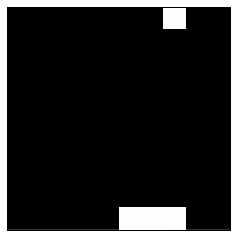

Action: 0


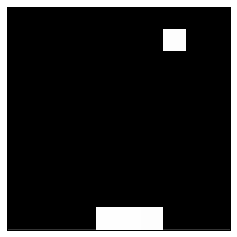

Action: 1


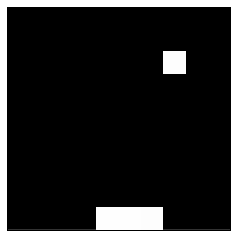

Action: 0


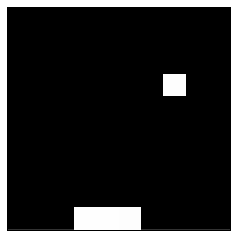

Action: 1


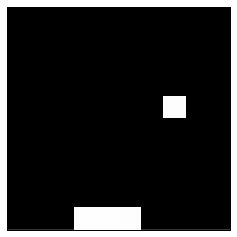

Action: 1


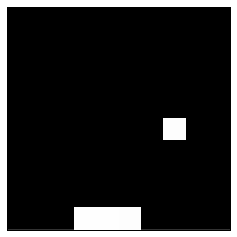

Action: 2


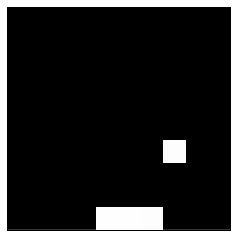

Action: 0


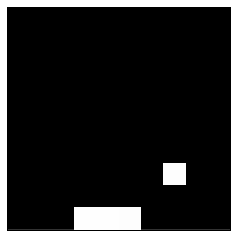

Action: 2


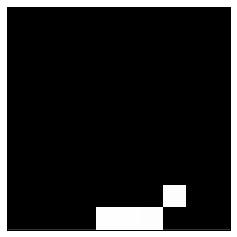

Action: 0


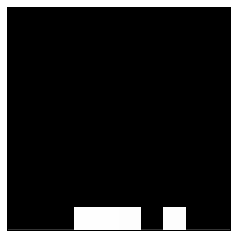

Final reward: -1


In [12]:
env.reset()
observation = env._get_observation()
env.render()
for i in range(9):
    action = env.action_space.sample()
    print("Action: {}".format(action))
    observation, reward, done, info = env.step(action)
    env.render()
print("Final reward: {}".format(reward))